In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,754 cases (7 day average) as of Fri 07 May, +21.7 since Thu 06 May
84 hospitalised (7 day average) as of Sun 09 May, +0.0 since Sun 09 May
8 died (7 day average) as of Fri 07 May, -0.4 since Thu 06 May


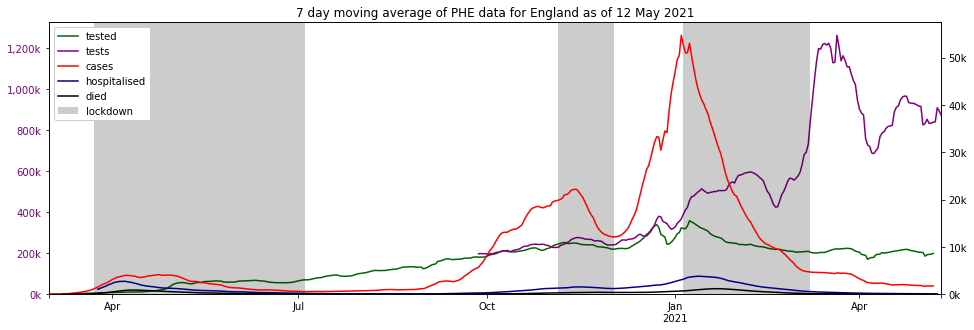

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

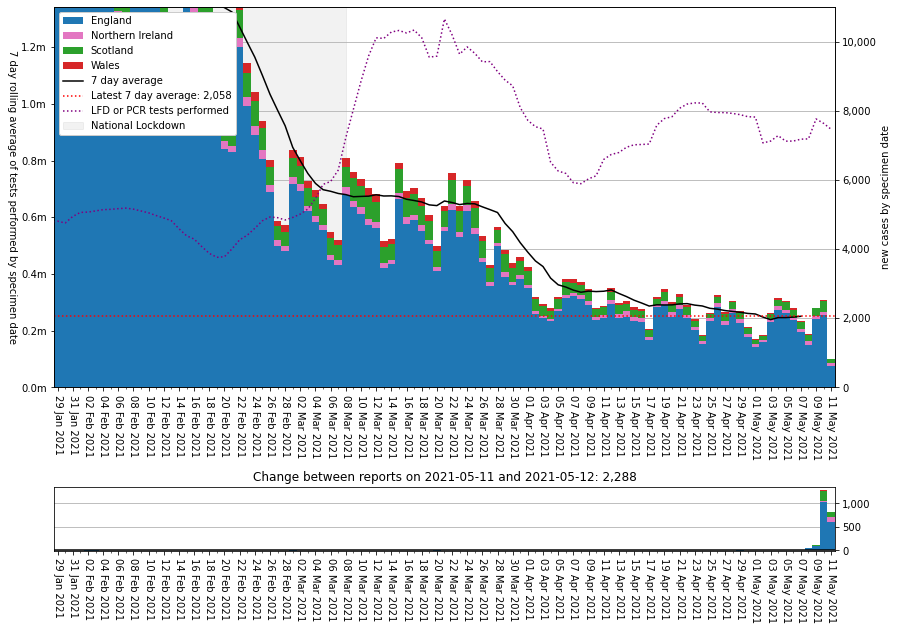

In [4]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

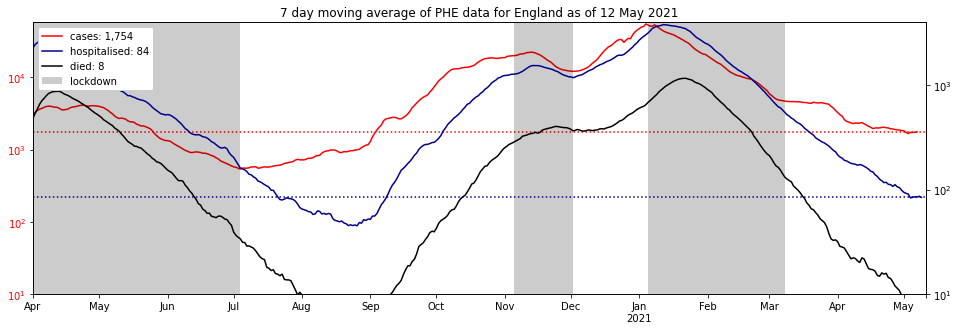

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

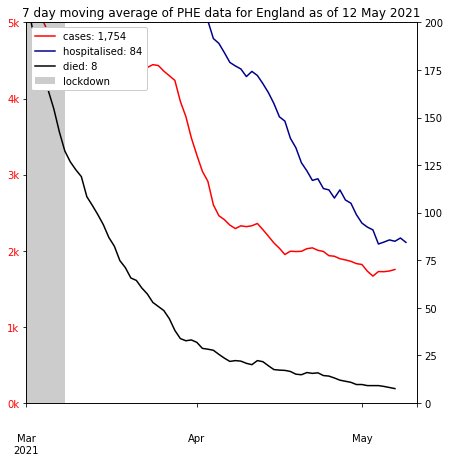

In [6]:
plot_summary(earliest_date='2021-03-01', show_latest=True, figsize=(7, 7),
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=5_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,11 May 21,"+15,533,159","+29,826,179","+15,533,159","+308,915","+98,515","+308,915"
Northern Ireland,11 May 21,"+515,015","+986,008","+515,015","+11,928","+3,970","+11,928"
Scotland,11 May 21,"+1,526,889","+2,948,604","+1,526,889","+20,276","+19,641","+20,276"
Wales,11 May 21,"+863,469","+1,961,670","+863,469","+9,028","+12,987","+9,028"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,15533159.0,29826179.0,14293020.0,56286961,27.596372,25.393128,47.010500
1,Northern Ireland,N92000002,515015.0,986008.0,470993.0,1893667,27.196704,24.872008,47.931289
2,Scotland,S92000003,1526889.0,2948604.0,1421715.0,5463300,27.948108,26.023008,46.028884
3,Wales,W92000004,863469.0,1961670.0,1098201.0,3152879,27.386684,34.831689,37.781628


'partial: 35,722,461 (53.5%), full: 18,438,532'

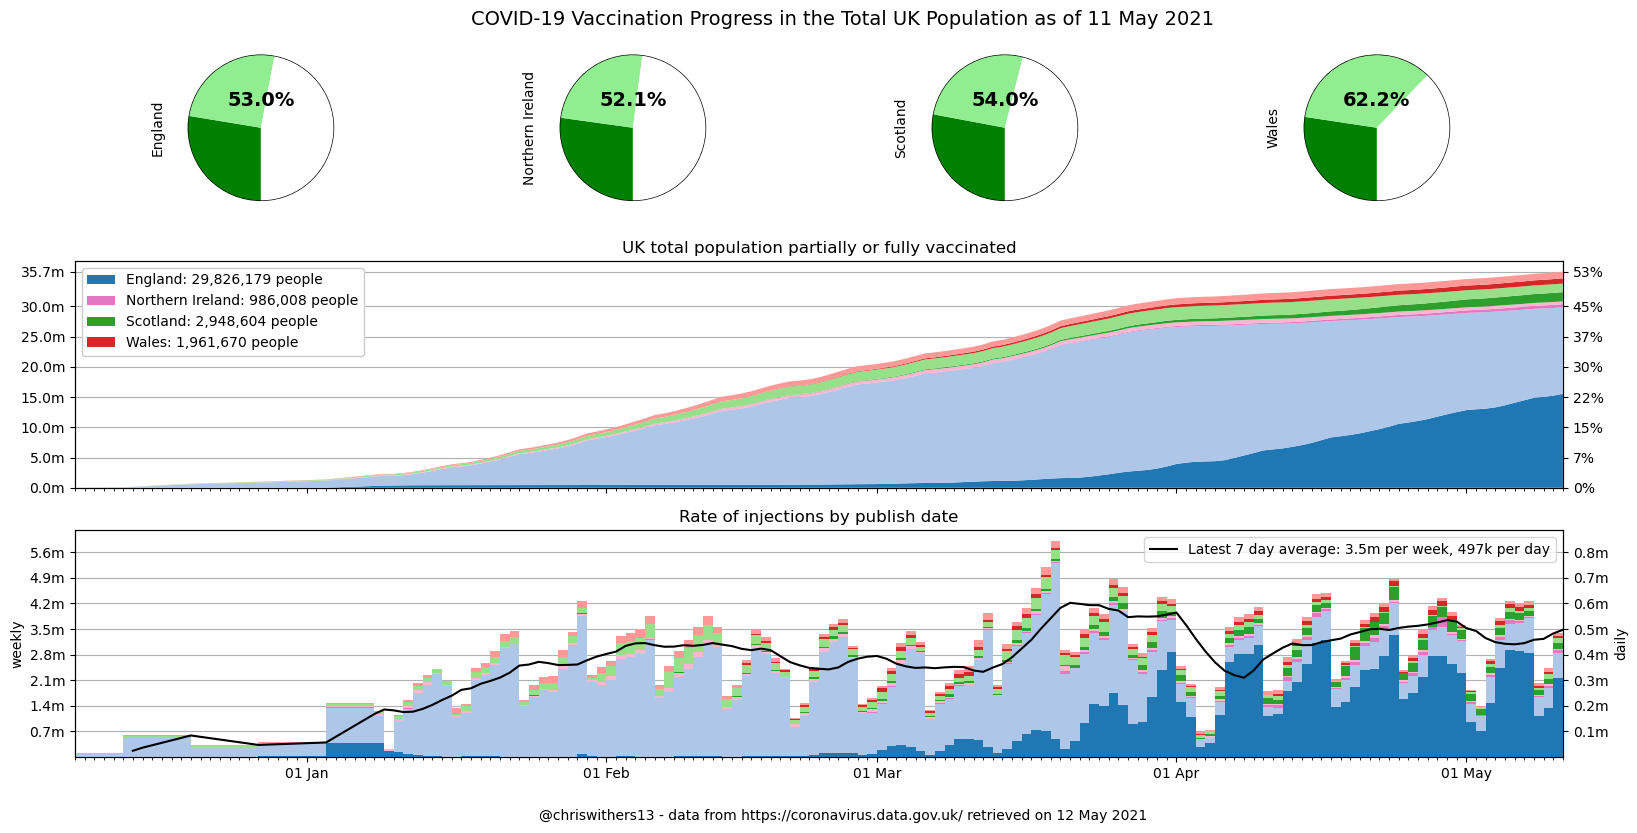

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

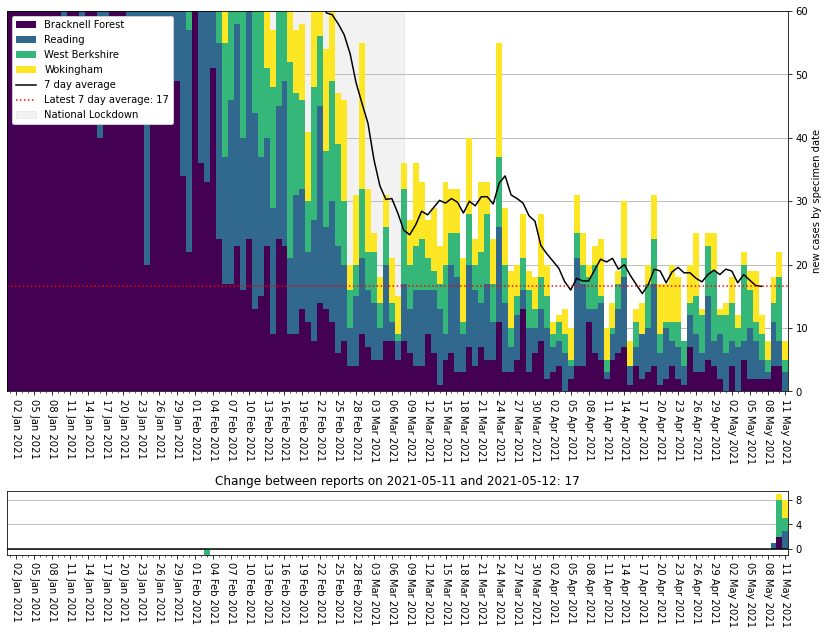

In [9]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=60)

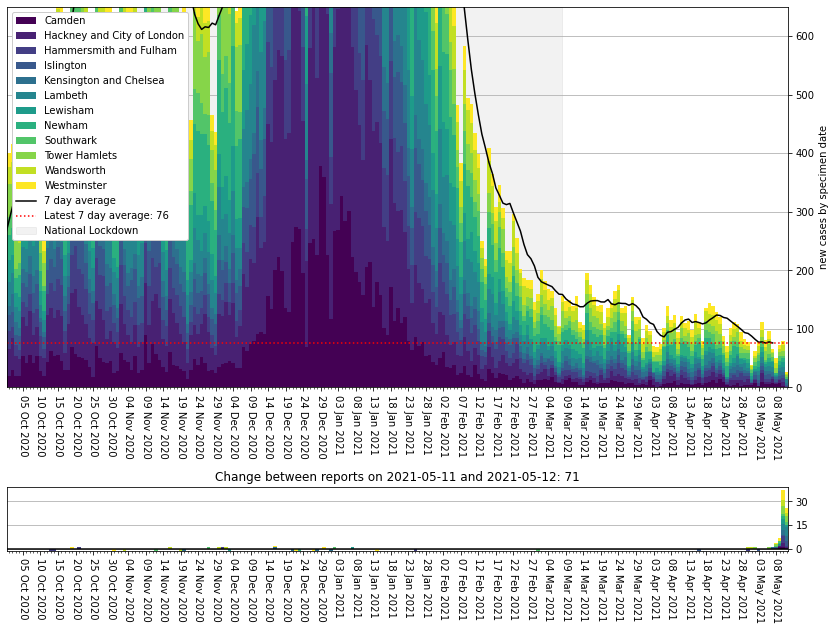

In [10]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,200.312989,576.0,2021-05-11
E07000036,Erewash,133.482418,154.0,2021-05-11
E06000055,Bedford,95.215013,165.0,2021-05-11
E06000008,Blackburn with Darwen,93.522873,140.0,2021-05-11
N09000005,Derry City and Strabane,91.880172,139.0,2021-05-11
S12000049,Glasgow City,68.391458,433.0,2021-05-11
S12000020,Moray,67.835525,65.0,2021-05-11
E07000169,Selby,58.485985,53.0,2021-05-11
E08000034,Kirklees,55.481403,244.0,2021-05-11


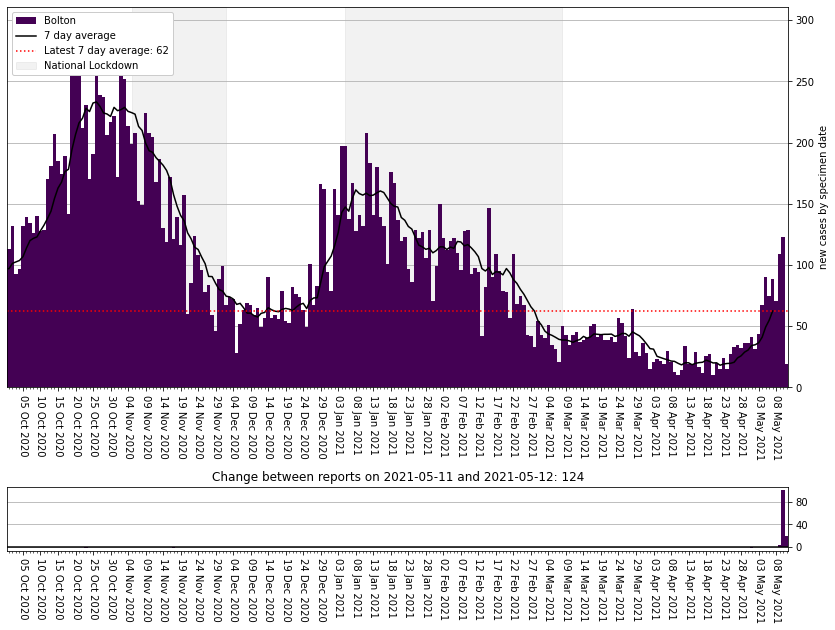

In [19]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,200.312989,576.0,2021-05-11
S12000049,Glasgow City,68.391458,433.0,2021-05-11
E08000035,Leeds,45.011026,357.0,2021-05-11
E08000019,Sheffield,44.968565,263.0,2021-05-11
E08000034,Kirklees,55.481403,244.0,2021-05-11
E08000032,Bradford,38.163979,206.0,2021-05-11
E08000003,Manchester,36.356533,201.0,2021-05-11
E08000025,Birmingham,15.764361,180.0,2021-05-11
E06000055,Bedford,95.215013,165.0,2021-05-11


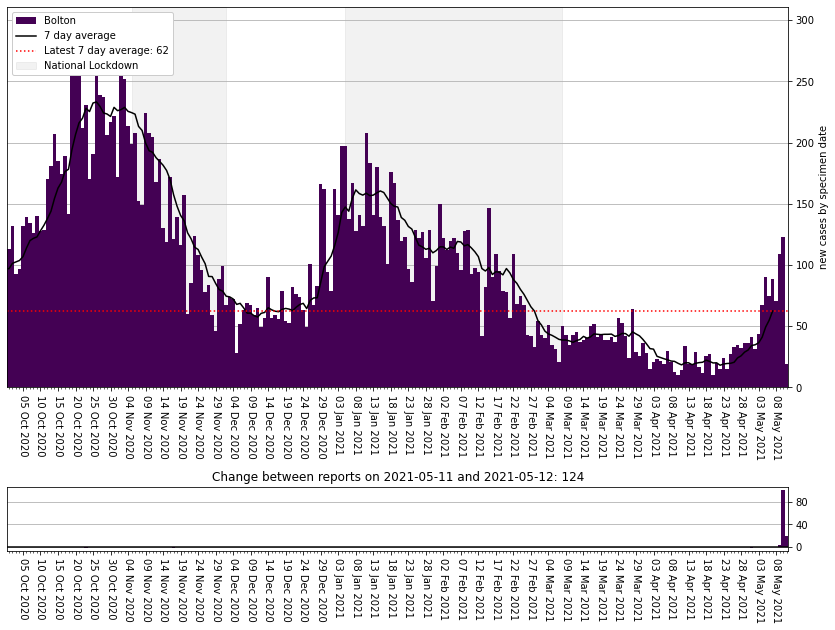

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.24

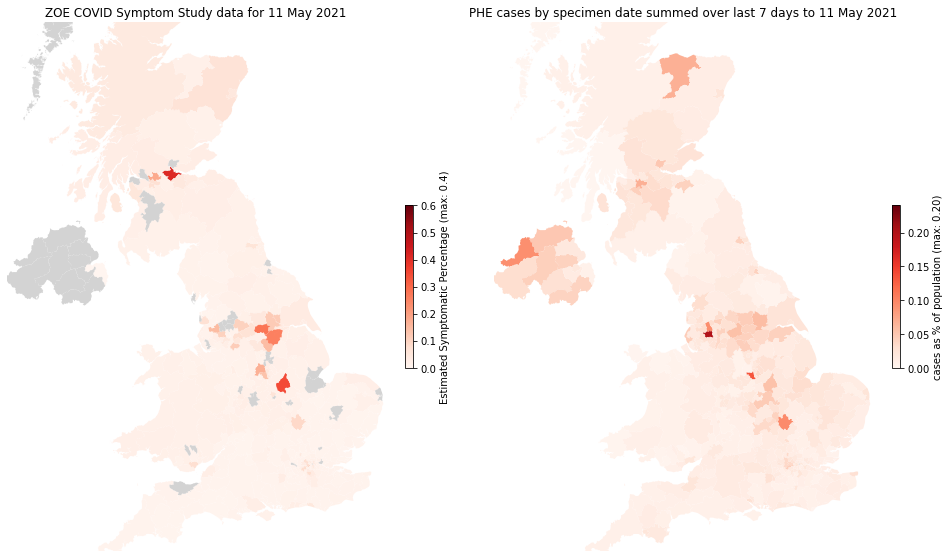

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...